<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/04_MtMonger%20fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.8 # np. indexing error on version above
      !pip install lavavu-osmesa==1.8.32 geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

# Imports

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/DEM.tif"

In [4]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [9]:
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

# Add data

In [10]:
MtMonger_pts = gpd.read_file(os.path.join(path_shp, "MtMonger_pts_elevation.shp"))
MtMonger_pts = pd.DataFrame({'X': MtMonger_pts.geometry.x, 
              'Y': MtMonger_pts.geometry.y, 
              'Z': MtMonger_pts.DEM_main})

MtMonger_pts['fault_name'] = "MtMonger Fault"

MtMonger_seismic = gpd.read_file(os.path.join(path_seismic, "MtMonger_fault.shp"))

MtMonger_seismic = MtMonger_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
MtMonger_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

MtMonger_seismic['fault_name'] = MtMonger_seismic['fault_name'].str.replace('Mount Monger Fault', "MtMonger Fault")

In [11]:
gs = []

tmpA = []
tmpB = []

xs = MtMonger_seismic['X'].to_numpy()
ys = MtMonger_seismic['Y'].to_numpy()
zs = MtMonger_seismic['Z'].to_numpy()

meanX = MtMonger_pts['X'].mean()
meanY = MtMonger_pts['Y'].mean()
meanZ = zs.max() # for this case, the vector norm couldn't be at the mean value, it was forcing too much the gradient

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['MtMonger Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [12]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_oris, ori])

In [13]:
updated_oris

,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853
1,Ida Fault,281825.127090,6.595975e+06,-19118.905000,0.455672,0.129275,0.865917
2,Bullabulling North Fault,288597.465546,6.618662e+06,-6250.689000,0.352245,0.102473,0.917071
3,Bulla_Abut_North,291113.118517,6.597520e+06,410.622447,0.000000,-0.996646,0.003071
4,Bullabulling South Fault,300390.029744,6.573092e+06,-6250.689000,0.352245,0.102473,0.917071
5,Bulla_Abut_South,298395.373188,6.581800e+06,404.589443,0.000000,0.043609,0.001308
6,Zuleika Fault,336167.443915,6.581425e+06,-3475.761250,-0.387965,-0.203100,-0.899018


In [14]:
updated_data = pd.concat([updated_data, MtMonger_seismic, MtMonger_pts])

In [15]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [16]:
updated_ori['fault_name'].unique()

array(['Kunanalling Fault', 'Ida Fault', 'Bullabulling North Fault',
       'Bulla_Abut_North', 'Bullabulling South Fault', 'Bulla_Abut_South',
       'Zuleika Fault', 'MtMonger Fault'], dtype=object)

In [17]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

##########################################
####### Faults from previous work ########
##########################################

model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)


# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14][0],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Kunanalling Fault'])

model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 24                     geological features that need to be interpolated



  0%|          | 0/24 [00:00<?, ?it/s]

Model update took: 77.77949547767639 seconds


Object exists: MtMonger Fault_value_cp
Object exists: MtMonger Fault_value_cp



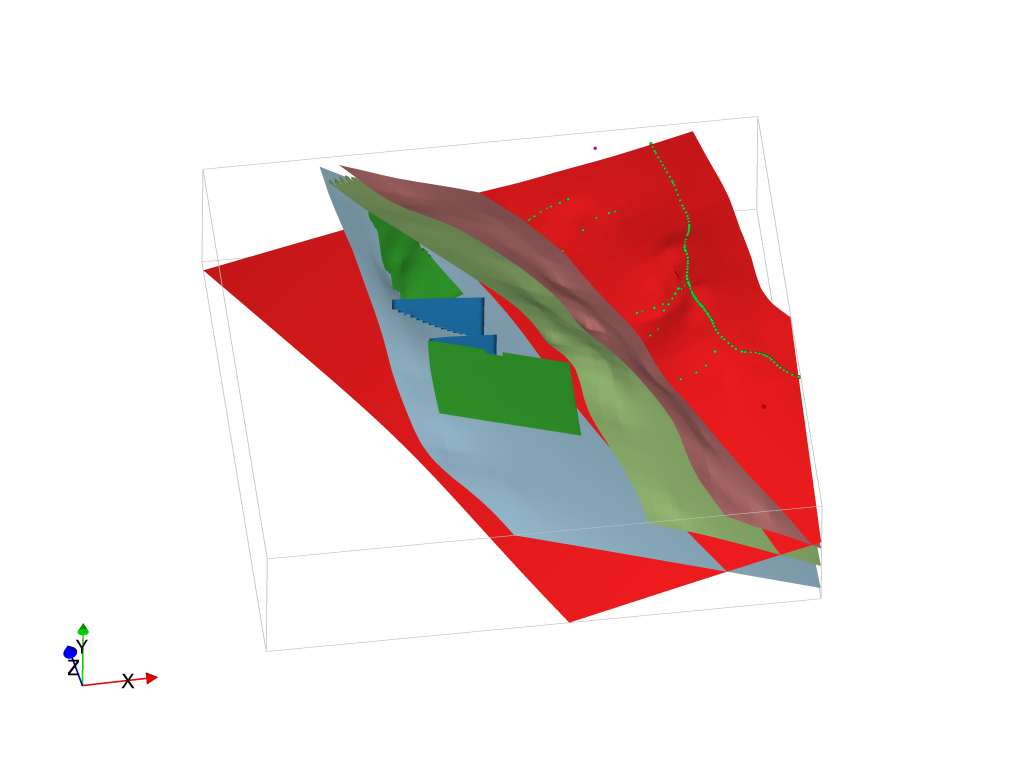

In [18]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

view.nelements = 1e8
view.nsteps = [100, 100, 200]

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_data(model['MtMonger Fault'], name = 'MtMonger Fault')
view.rotation = [-38.762203216552734, 4.903929233551025, 5.440668106079102]
# view.interactive()
view.display()

In [19]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)